We have dataset from Asle, processed with 2 pointers to find repeatitions in Lakh MIDI Clean midi files

In [1]:
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
def analyze_datasets_folder(root_dir='/datasets'):
    """
    Analyzes the dataset folder and provides statistics about the number of files, MIDI files, and file extension distribution.

    Args:
        root_dir (str): The root directory of the dataset. Default is '/datasets'.
    """
    total_files = 0
    midi_files = 0
    folder_count = 0
    file_extensions = Counter()

    for root, dirs, files in os.walk(root_dir):
        folder_count += 1
        total_files += len(files)
        
        for file in files:
            _, ext = os.path.splitext(file)
            if ext:
                file_extensions[ext.lower()] += 1
            else:
                file_extensions['(no extension)'] += 1
            
            if ext.lower() in ['.mid', '.midi']:
                midi_files += 1

    print(f"Total number of folders: {folder_count}")
    print(f"Total number of files: {total_files}")
    print(f"Number of MIDI files: {midi_files}")
    
    print("\nFile extension distribution:")
    for ext, count in file_extensions.most_common():
        print(f"{ext}: {count}")
    
    print("\nPercentage breakdown:")
    sorted_extensions = sorted(file_extensions.items(), key=lambda x: x[1], reverse=True)
    
    for ext, count in sorted_extensions[:5]:  # Show top 5 extensions
        percentage = (count / total_files) * 100
        print(f"{ext}: {percentage:.2f}%")

    other_count = sum(count for ext, count in sorted_extensions[5:])
    other_percentage = (other_count / total_files) * 100
    print(f"Others: {other_percentage:.2f}%")

In [3]:
# checking the dataset folder's path
!ls -la

total 120
drwxr-xr-x@ 3 serdegsenere  staff     96 Sep 26 12:56 .
drwxr-xr-x  7 serdegsenere  staff    224 Sep 26 12:55 ..
-rw-r--r--@ 1 serdegsenere  staff  59616 Sep 27 15:27 Clustering_repeated_motifs.ipynb


In [4]:
os.getcwd()

'/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/testing_tools/clustering'

ipynb has different paths concept, ok, let's use full path instead

In [5]:
# checking the dataset folder, NOTE that it is in gitignore, so it is not pushed to github
analyze_datasets_folder("/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only") 

Total number of folders: 3484
Total number of files: 7669
Number of MIDI files: 7662

File extension distribution:
.mid: 7662
(no extension): 7

Percentage breakdown:
.mid: 99.91%
(no extension): 0.09%
Others: 0.00%


The plan for this ipynb something like this

	1.	Preprocessing
			Parsing MIDI files with mido or better pretty_midi
			Extract key features -- note sequences, rhythm, harmony
			Normalize key and tempo
	2.	Feature representation
			Convert MIDI files to fixed-length vectors (bag-of-notes, TF-IDF, autoencoders??)
			Use dimensionality reduction if needed?
	3.	Similarity measurement
			Distance metrics like Euclidean, Cosine, DTW
	4.	Efficient retrieval
			Indexing structures like FAISS or LSH for fast searches?
	5.	Building the program for integreation later

(add references)

In [6]:
!pip install mido
!pip install pretty_midi
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install faiss-cpu  # for similarity search

In [7]:
import os
import numpy as np
import pretty_midi
import faiss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
def extract_features(file_path):
    """
    Extract features from a MIDI file.

    Args:
        file_path (str): The path to the MIDI file.

    Returns:
        numpy.ndarray: A feature vector representing the MIDI file.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
    except:
        print(f"Error loading {file_path}")
        return None
    
    # Initialize lists to hold features
    pitches = []
    durations = []
    velocities = []
    
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                pitches.append(note.pitch)
                durations.append(note.end - note.start)
                velocities.append(note.velocity)
    
    if not pitches:
        return None  # Skip files with no notes
    
    # Convert lists to numpy arrays
    pitches = np.array(pitches)
    durations = np.array(durations)
    velocities = np.array(velocities)
    
    # Combine features into a single vector
    feature_vector = np.concatenate((pitches, durations, velocities))
    return feature_vector

In [9]:
def extract_rhythmic_features(midi_data): # FOR LATER
    """
    Extract rhythmic features from a MIDI file.

    Args:
        midi_data (pretty_midi.PrettyMIDI): The MIDI data.

    Returns:
        numpy.ndarray: A feature vector representing the rhythmic features.
    """
    # Calculate inter-onset intervals (IOIs)
    onset_times = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            onset_times.extend([note.start for note in instrument.notes])
    onset_times = sorted(onset_times)
    iois = np.diff(onset_times)
    return iois

In [10]:
def process_dataset(dataset_folder):
    """
    Process a dataset folder and extract features from all MIDI files.

    Args:
        dataset_folder (str): The path to the dataset folder.

    Returns:
        tuple: A tuple containing two lists - feature_list and file_names.
    """
    feature_list = []
    file_names = []

    for root, _, files in os.walk(dataset_folder):
        for file_name in files:
            if file_name.lower().endswith(('.mid', '.midi')):
                file_path = os.path.join(root, file_name)
                features = extract_features(file_path)
                if features is not None:
                    feature_list.append(features)
                    file_names.append(file_path)
                else:
                    print(f"Skipping {file_name} due to extraction issues.")
    
    return feature_list, file_names

In [11]:
# note that this folder is in gitignore, so it is not pushed to github, I took it from Teams
dataset_folder = "/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only"

In [ ]:
os.listdir(dataset_folder)

In [13]:
# let's try to process only a part of the dataset
feature_list, file_names = process_dataset("/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns")


In [14]:
# let's see the first 10 file names
len(file_names)

22

In [15]:
# let's see 10 files
print("total files itn the folder is " + str(len(file_names)))
file_names[0:10]



total files itn the folder is 22


['/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Stuck.mid/track1.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Stuck.mid/track0.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Faith.mid/track2.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Faith.mid/track1.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Faith.mid/track0.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/N_2_Gether_Now.mid/track1.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/N_2_Gether_Now.mid/track0.mid',
 '

In [16]:
# vector of features for the 1st file
feature_list[0:1]

[array([ 38.        ,  45.        ,  50.        ,  38.        ,
         45.        ,  50.        ,  47.        ,  54.        ,
         59.        ,  46.        ,  53.        ,  58.        ,
         38.        ,  45.        ,  50.        ,  38.        ,
         45.        ,  50.        ,  40.        ,  47.        ,
         52.        ,  38.        ,  45.        ,  41.        ,
         48.        ,  53.        ,  38.        ,  45.        ,
         40.        ,  47.        ,  52.        ,  41.        ,
         48.        ,  53.        ,  49.        ,  50.        ,
         38.        ,  49.        ,  50.        ,  38.        ,
         49.        ,  50.        ,  38.        ,  49.        ,
         50.        ,  38.        ,  49.        ,  50.        ,
         49.        ,  50.        ,  50.        ,  57.        ,
         62.        ,  51.        ,  58.        ,  63.        ,
         50.        ,  57.        ,  62.        ,  51.        ,
         58.        ,  63.        ,  63.

In [17]:
# let's see the shape of the 1st, 2nd and 3rd file
print(np.shape(feature_list[0:1]))  
print(np.shape(feature_list[1:2]))
print(np.shape(feature_list[2:3]))



(1, 270)
(1, 204)
(1, 108)


oi, oi oi, this difference in vector sizes will create problems as many ML algorithms expect fixed length inputs


In [18]:
# analyzing the lengths of the feature vectors
feature_lengths = [len(f) for f in feature_list]
fixed_length = min(6666, max(feature_lengths))  # set an upper limit here
print(f"Using fixed length: {fixed_length}")

Using fixed length: 288


In [19]:
def pad_or_truncate(features, fixed_length):
    """
    Pad or truncate the feature vector to the fixed length.

    Args:
        features (numpy.ndarray): The feature vector to pad or truncate.
        fixed_length (int): The length to which the feature vector should be padded or truncated.

    Returns:
        numpy.ndarray: The padded or truncated feature vector.
    """
    if len(features) >= fixed_length:
        return features[:fixed_length]
    else:
        padding = np.zeros(fixed_length - len(features))
        return np.concatenate((features, padding))

In [20]:
# Apply to all feature vectors
processed_features = [pad_or_truncate(f, fixed_length) for f in feature_list]
processed_features = np.array(processed_features)

# Normalize the features
scaler = StandardScaler()
processed_features = scaler.fit_transform(processed_features)

### Similarity Search Index
FAISS for efficient similarity searches in high-dimensional spaces

FAISS -- Facebook AI Similarity Search (https://ai.meta.com/tools/faiss/)

In [21]:
n_samples, n_features = processed_features.shape

print(f"Number of samples: {n_samples}")
print(f"Number of features per sample: {n_features}")


Number of samples: 22
Number of features per sample: 288


In [22]:
# Convert features to float32 as required by FAISS
processed_features = processed_features.astype('float32')

# Use PCA to reduce dimensionality for efficiency
# pca_dimensions = 256  # adjust based on performance

pca_dimensions = min(n_samples, n_features) - 1  # or any number less than 22 for now

pca = PCA(n_components=pca_dimensions)
processed_features_pca = pca.fit_transform(processed_features)

# Initialize the FAISS index
dimension = pca_dimensions
index = faiss.IndexFlatL2(dimension)

# Add vectors to the index
index.add(processed_features_pca)

In [23]:
def find_similar_midi(query_file_path, k=5): # FOR LATER
    """
    Find similar MIDI files to the query file.

    Args:
        query_file_path (str): The path to the query MIDI file.
        k (int): The number of similar files to return. Default is 5.

    Returns:
        tuple: A tuple containing a list of similar file paths and their distances.
    """
    query_features = extract_features(query_file_path)
    if query_features is None:
        print("Failed to extract features from the query file.")
        return [], []
    
    # Pad or truncate and normalize
    query_features = pad_or_truncate(query_features, fixed_length)
    query_features = scaler.transform([query_features])
    query_features = pca.transform(query_features)
    query_features = query_features.astype('float32')
    
    # Perform the search
    distances, indices = index.search(query_features, k)
    
    similar_files = [file_names[i] for i in indices[0]]
    return similar_files, distances[0]

main with all the stuff

In [25]:
# Create a DataFrame
df_features = pd.DataFrame(feature_list)
df_features['file_name'] = file_names

print(f"Extracted features for {len(df_features)} files.")

Extracted features for 22 files.


In [40]:
print(df_features.shape)
print(df_features.columns)
print(df_features.head())

(22, 289)
Index([          0,           1,           2,           3,           4,
                 5,           6,           7,           8,           9,
       ...
               279,         280,         281,         282,         283,
               284,         285,         286,         287, 'file_name'],
      dtype='object', length=289)
      0     1     2     3     4     5     6     7     8     9  ...  279  280  \
0  38.0  45.0  50.0  38.0  45.0  50.0  47.0  54.0  59.0  46.0  ...  NaN  NaN   
1  40.0  47.0  53.0  52.0  40.0  47.0  53.0  52.0  40.0  47.0  ...  NaN  NaN   
2  33.0  40.0  45.0  23.0  40.0  38.0  35.0  23.0  23.0  23.0  ...  NaN  NaN   
3  47.0  54.0  59.0  52.0  57.0  35.0  35.0  35.0  35.0  47.0  ...  NaN  NaN   
4  47.0  54.0  59.0  63.0  47.0  54.0  59.0  63.0  47.0  54.0  ...  NaN  NaN   

   281  282  283  284  285  286  287  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN  Na

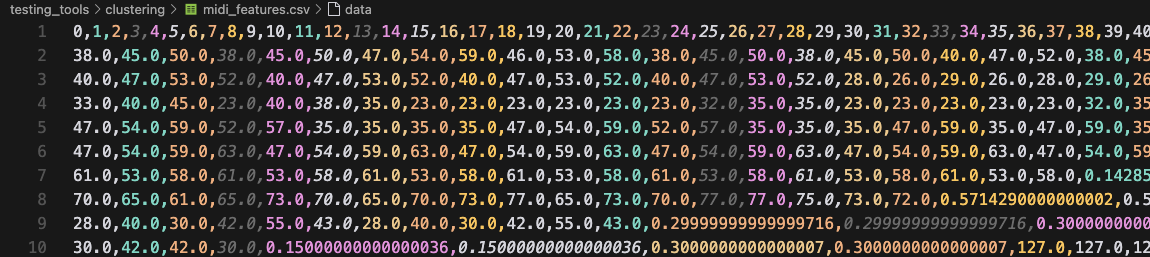

In [41]:
print(df_features.isna().sum())

0             0
1             0
2             0
3             0
4             0
             ..
284          21
285          21
286          21
287          21
file_name     0
Length: 289, dtype: int64


In [37]:
df_features_clean = df_features.dropna()

In [38]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df_features_clean = pd.DataFrame(imputer.fit_transform(df_features.iloc[:, :-1]), columns=df_features.columns[:-1])

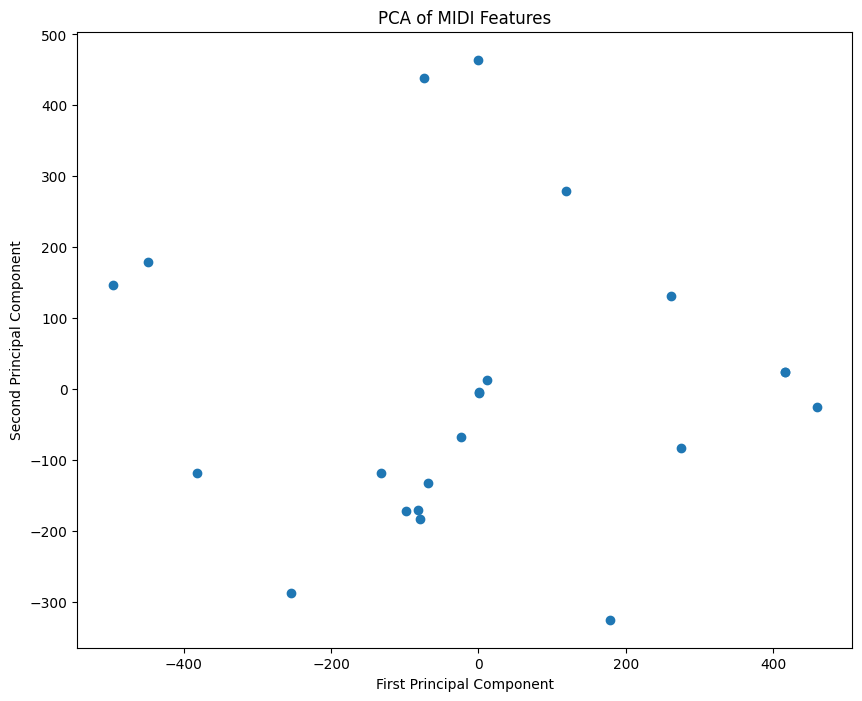

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_features_clean)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of MIDI Features')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


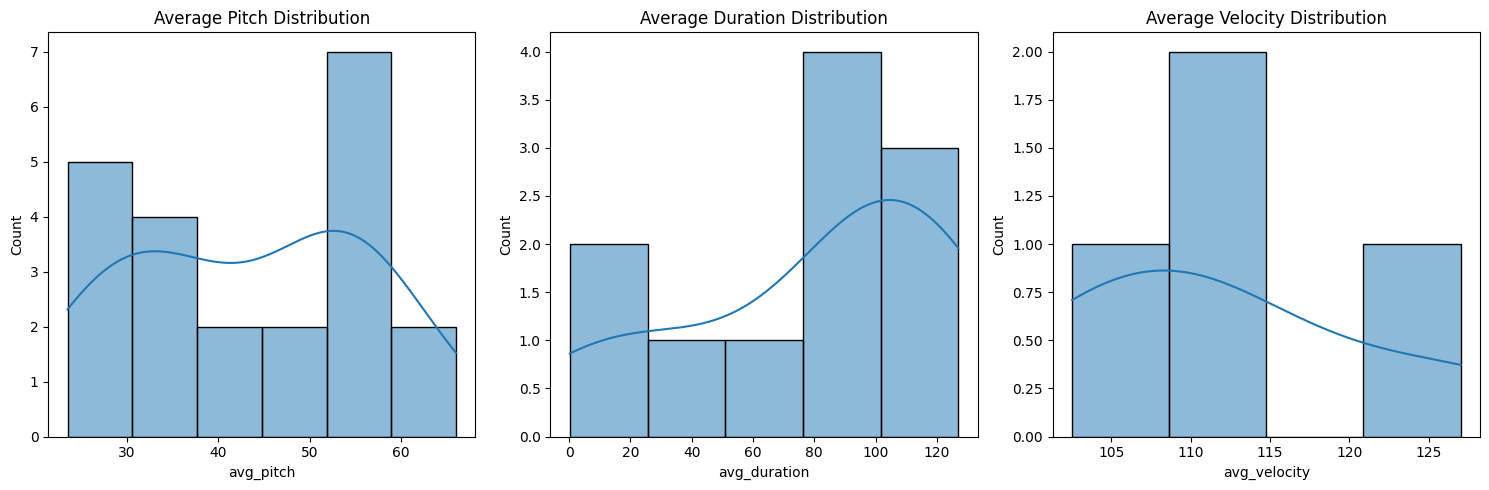

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(df['avg_pitch'], kde=True)
plt.title('Average Pitch Distribution')

plt.subplot(132)
sns.histplot(df['avg_duration'], kde=True)
plt.title('Average Duration Distribution')

plt.subplot(133)
sns.histplot(df['avg_velocity'], kde=True)
plt.title('Average Velocity Distribution')

plt.tight_layout()
plt.show()

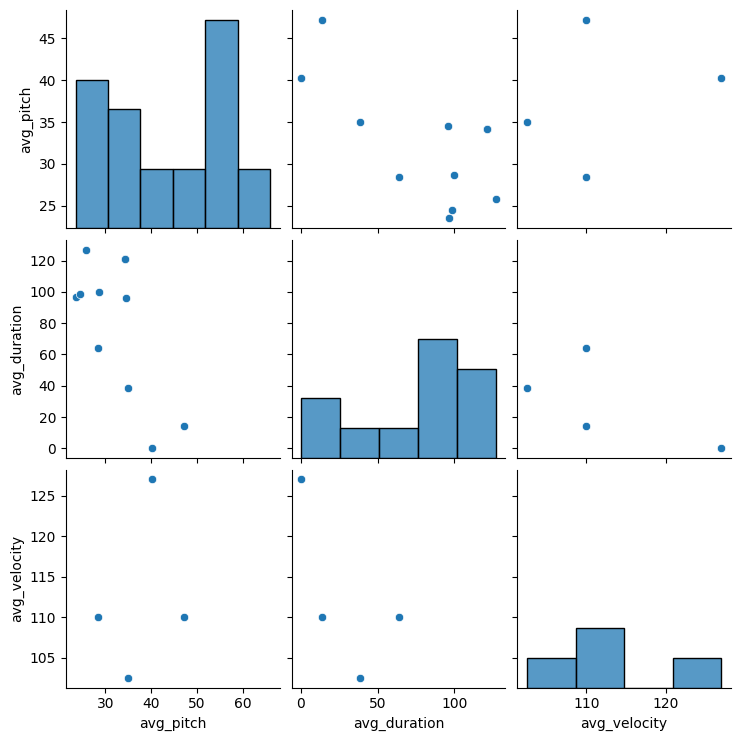

In [77]:
sns.pairplot(df[['avg_pitch', 'avg_duration', 'avg_velocity']])
plt.show()

In [ ]:
def main(): # FOR LATER
    query_file = input("Enter the path to the MIDI file you want to compare: ")
    if not os.path.exists(query_file):
        print("File does not exist.")
        return
    
    k = int(input("Enter the number of similar files to retrieve: "))
    similar_files, distances = find_similar_midi(query_file, k)
    
    print("\nMost similar MIDI files:")
    for file, distance in zip(similar_files, distances):
        print(f"{file} (Distance: {distance})")
    
if __name__ == '__main__':
    main()